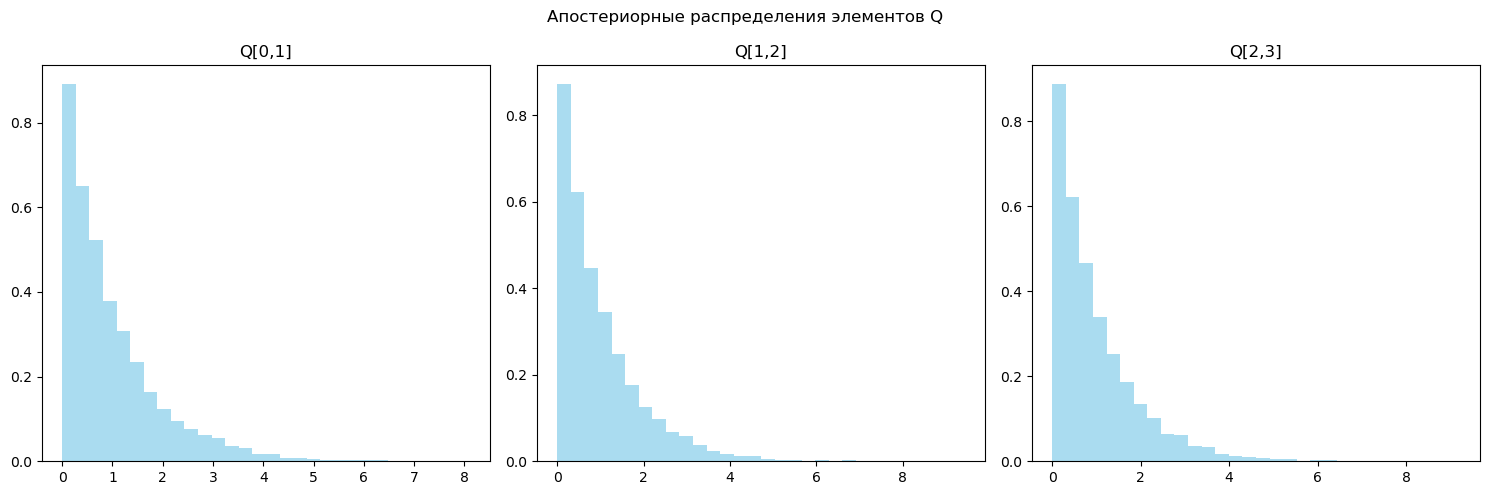

In [38]:
import numpy as np
from scipy.stats import expon, gamma
import matplotlib.pyplot as plt

# Настройки
n_states = 4  # количество состояний (например: AAA, AA, A, дефолт)
alpha = 1.0   # параметр Дирихле/гамма-распределения
beta = 1.0
num_iters = 10000
burn_in = 2000

# Начальная матрица Q
initial_q = np.array([
    [-0.3, 0.2, 0.1, 0.0],
    [0.0, -0.4, 0.3, 0.1],
    [0.0, 0.0, -0.5, 0.5],
    [0.0, 0.0, 0.0, 0.0]  # дефолт – поглощающее состояние
])

def simulate_jumps(q, max_time=100):
    current_state = 0
    jumps = []
    time = 0.0
    
    while time < max_time and current_state != n_states - 1:
        rate = -q[current_state, current_state]
        if rate <= 0:
            break

        dwell_time = expon.rvs(scale=1/rate)
        probs = q[current_state, :].copy()
        probs[current_state] = 0
        probs = np.maximum(probs, 0)
        if probs.sum() <= 0:
            break
        probs /= probs.sum()
        
        next_state = np.random.choice(n_states, p=probs)
        jumps.append((current_state, next_state, dwell_time))
        time += dwell_time
        current_state = next_state
    return jumps

def update_q(q, jumps):
    n_ij = np.zeros((n_states, n_states))
    r_i = np.zeros(n_states)
    
    for (i, j, t) in jumps:
        n_ij[i, j] += 1
        r_i[i] += t

    new_q = np.zeros_like(q)
    for i in range(n_states - 1):  # дефолт не обновляется
        for j in range(n_states):
            if i != j:
                new_alpha = alpha + n_ij[i, j]
                new_beta = beta + r_i[i]
                new_q[i, j] = gamma.rvs(new_alpha, scale=1/new_beta)
        new_q[i, i] = -np.sum(new_q[i, :])
    return new_q

# BMCMC-итерации
samples = []
q = initial_q.copy()

for it in range(num_iters):
    jumps = simulate_jumps(q)
    q = update_q(q, jumps)
    
    if it >= burn_in:
        samples.append(q.copy())

# Пример: гистограммы некоторых элементов Q
samples = np.array(samples)
plt.figure(figsize=(15, 5))
for idx, (i, j) in enumerate([(0, 1), (1, 2), (2, 3)]):
    plt.subplot(1, 3, idx + 1)
    plt.hist(samples[:, i, j], bins=30, density=True, alpha=0.7, color='skyblue')
    plt.title(f"Q[{i},{j}]")
plt.suptitle("Апостериорные распределения элементов Q")
plt.tight_layout()
plt.show()


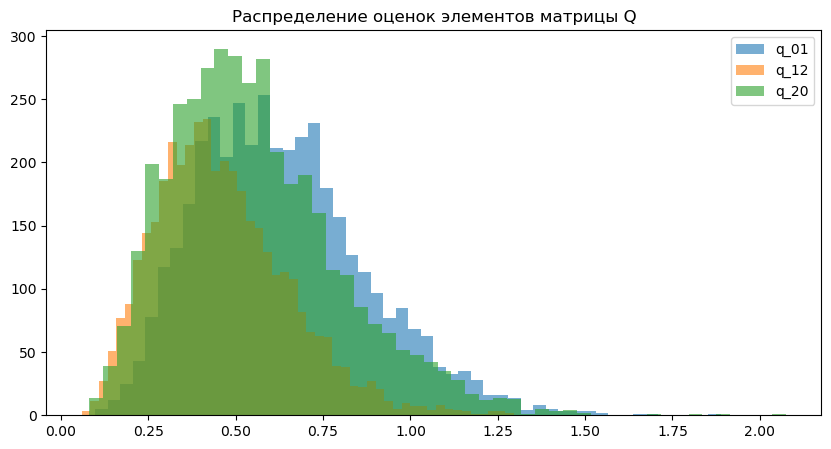

In [42]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def bmcmc_simulation(N, R, alpha, beta, num_samples=4000):
    """
    Байесовская MCMC-оценка матрицы переходных вероятностей.
    
    :param N: матрица наблюдаемых переходов (размер m x m)
    :param R: вектор времени пребывания в состояниях (размер m)
    :param alpha: априорные параметры формы гамма-распределения (размер m x m)
    :param beta: априорные параметры масштаба гамма-распределения (размер m)
    :param num_samples: количество итераций MCMC
    :return: массив сгенерированных матриц Q
    """
    m = N.shape[0]  # Количество состояний
    samples = np.zeros((num_samples, m, m))
    
    for s in range(num_samples):
        Q = np.zeros((m, m))
        for i in range(m):
            for j in range(m):
                if i != j:
                    shape = N[i, j] + alpha[i, j]
                    scale = 1 / (R[i] + beta[i])
                    Q[i, j] = np.random.gamma(shape, scale)
            Q[i, i] = -np.sum(Q[i, :])  # Диагональные элементы
        samples[s] = Q
    
    return samples

m = 3 # Число состояний
N = np.array([[0, 5, 3], [2, 0, 4], [3, 1, 0]])  # Количество переходов
R = np.array([10, 12, 8])  # Время пребывания в состояниях
alpha = np.ones((m, m)) * 2  # Априорное значение alpha
beta = np.ones(m) * 1  # Априорное значение beta

samples = bmcmc_simulation(N, R, alpha, beta)

plt.figure(figsize=(10, 5))
plt.hist(samples[:, 0, 1], bins=50, alpha=0.6, label='q_01')
plt.hist(samples[:, 1, 2], bins=50, alpha=0.6, label='q_12')
plt.hist(samples[:, 2, 0], bins=50, alpha=0.6, label='q_20')
plt.legend()
plt.title("Распределение оценок элементов матрицы Q")
plt.show()


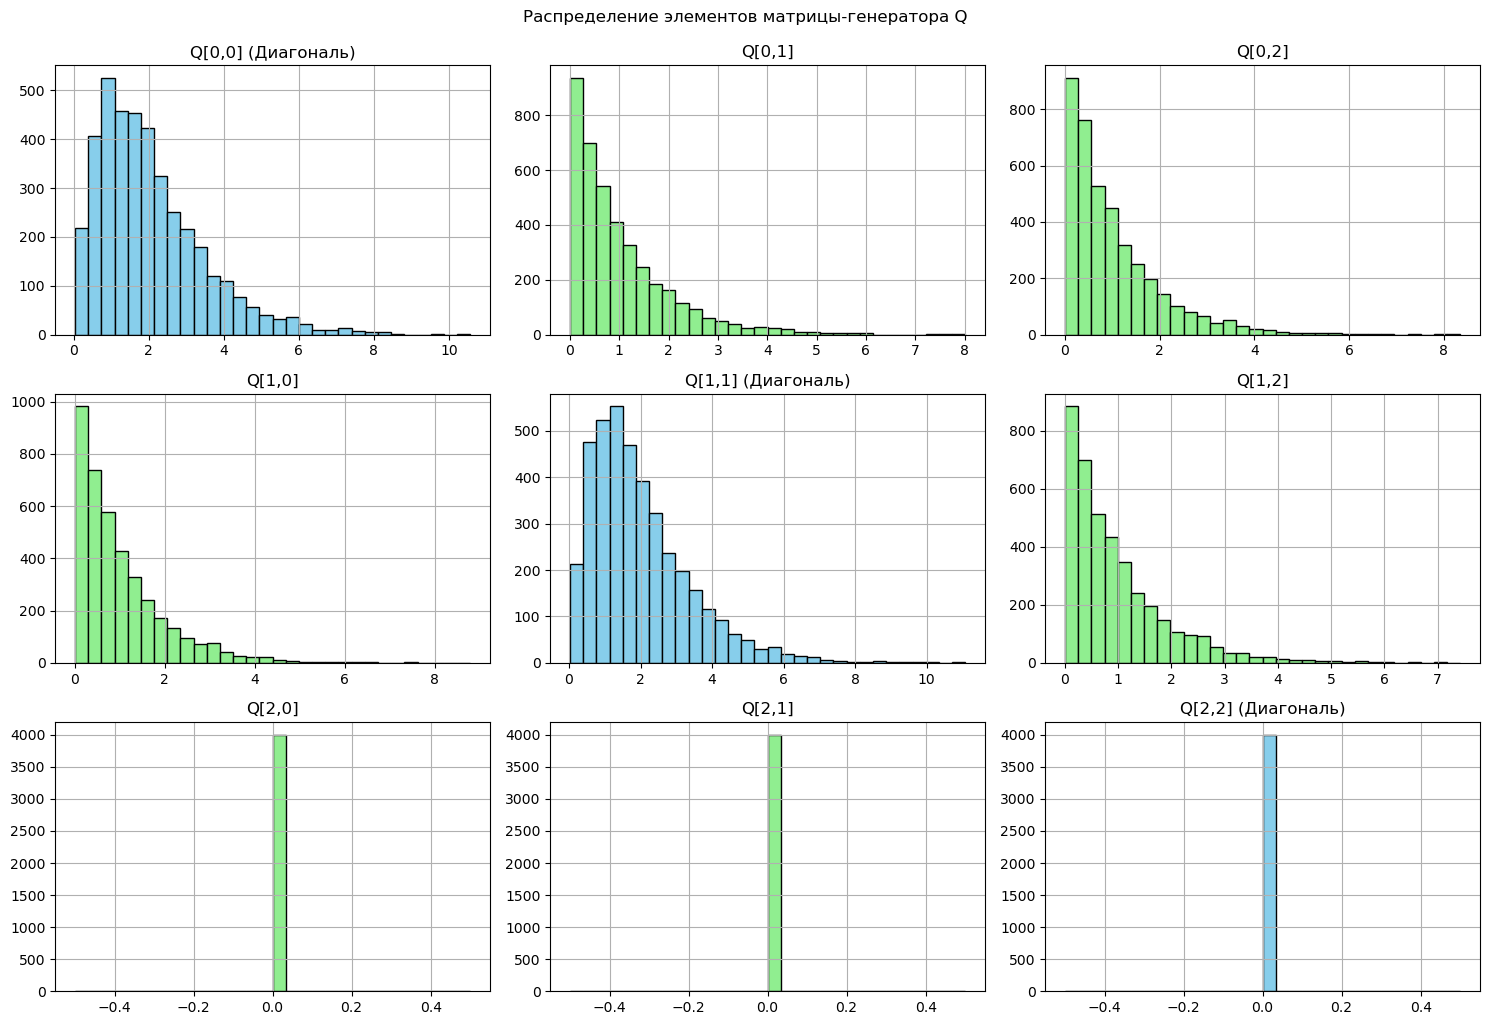

тоговая оценка матрицы Q:
[[-2.048  1.025  1.022]
 [ 1.024 -2.006  0.983]
 [ 0.     0.     0.   ]]


In [40]:
import numpy as np
from scipy.stats import gamma, expon
import matplotlib.pyplot as plt

# param
states = ['A', 'B', 'D']
n_states = len(states)
burn_in = 1000
iterations = 4000
alpha = 1.0
beta = 1.0

# Inicialization Q
def initialize_q():
    q = np.zeros((n_states, n_states))
    for i in range(n_states - 1):
        for j in range(n_states):
            if i != j:
                q[i, j] = gamma.rvs(alpha, scale=1/beta)
        q[i, i] = -np.sum(q[i, :])
    return q

# Simulation
def simulate_jumps(q, max_time=100):
    current_state = 0
    jumps = []
    time = 0.0
    
    while time < max_time and current_state != n_states - 1:
        rate = -q[current_state, current_state]
        if rate <= 0:
            break
            
        dwell_time = expon.rvs(scale=1/rate)
        probs = q[current_state, :].copy()
        probs[current_state] = 0
        probs = np.maximum(probs, 0)
        if probs.sum() <= 0:
            break
        probs /= probs.sum()
        
        next_state = np.random.choice(n_states, p=probs)
        jumps.append((current_state, next_state, dwell_time))
        time += dwell_time
        current_state = next_state
    return jumps

# Update Q
def update_q(q, jumps):
    n_ij = np.zeros((n_states, n_states))
    r_i = np.zeros(n_states)
    
    for (i, j, t) in jumps:
        n_ij[i, j] += 1
        r_i[i] += t
    
    new_q = np.zeros_like(q)
    for i in range(n_states - 1):
        for j in range(n_states):
            if i != j:
                new_alpha = alpha + n_ij[i, j]
                new_beta = beta + r_i[i]
                new_q[i, j] = gamma.rvs(new_alpha, scale=1/new_beta)
        new_q[i, i] = -np.sum(new_q[i, :])
    return new_q

# MCMC
# np.random.seed(42)
q_chain = []
current_q = initialize_q()

for step in range(burn_in + iterations):
    jumps = simulate_jumps(current_q)
    if len(jumps) > 0:
        current_q = update_q(current_q, jumps)
    
    if step >= burn_in and len(jumps) > 0:
        q_chain.append(current_q.copy())

# Main body
if q_chain:
    q_chain = np.array(q_chain)
    fig, axes = plt.subplots(n_states, n_states, figsize=(15, 10))
    
    for i in range(n_states):
        for j in range(n_states):
            ax = axes[i, j]
            if i == j:
                ax.set_title(f'Q[{i},{j}] (Диагональ)')
                ax.hist(-q_chain[:, i, i], bins=30, color='skyblue', edgecolor='black')
            else:
                ax.set_title(f'Q[{i},{j}]')
                ax.hist(q_chain[:, i, j], bins=30, color='lightgreen', edgecolor='black')
            ax.grid(True)
    
    plt.tight_layout()
    plt.suptitle('Распределение элементов матрицы-генератора Q', y=1.02)
    plt.show()
    
    # Вывод итоговой оценки
    final_q = np.mean(q_chain, axis=0)
    print("тоговая оценка матрицы Q:")
    print(np.round(final_q, 3))
else:
    print("Не удалось получить оценки.")